<light>First some imports we need</light>

In [1]:
import operator, math, random, csv
import numpy as np
import pandas as pd
import datetime
import helper.tree_plot as helper
from deap import base, creator, tools, gp, algorithms

# 1. Defining the building blocks
<p>
    In this first step we define the PrimitiveSet <code>pset</code>. The <code>pset</code> contains  the base functions, constants and the definition of input parameters. In following steps trees are     build out of these components.
</p>
</br>
<p>
    Generate a PrimitiveSetType Object with two input parameters (first one is a boolean and second one is a float). The return value of the result (the root node in the tree) should be a float value.
</p>

In [3]:
pset = gp.PrimitiveSetTyped("main", [float], float)

Define primitive functions for the nodes. The first parameter defines the function, the second the types of the input parameters and the third one the type of the output.

In [4]:
pset.addPrimitive(operator.mul, [float, float], float)
pset.addPrimitive(operator.add, [float, float], float)
pset.addPrimitive(helper.protectedDiv, [float, float], float)
pset.addPrimitive(operator.sub, [float, float], float)
# pset.addPrimitive(helper.if_then_else, [int, float, float], float)

Secondly define some constants for the terminals (leafs in the tree)

In [5]:
for i in range(10):
    pset.addTerminal(i, float)

Define names for the input parameters

In [6]:
pset.renameArguments(ARG0="x")
# pset.renameArguments(ARG1="y")

# 2. Defining Object types
In any evolutionary program, we need some basic object types. In this case we need two, a fitness type and the type for individuals. In this problem we are facing an maximization and minimization problem (maximize the value and minimize the tree size)(so the one value is positive and the other one is negative). The individual will be based upon a tree, to which we  add the defined fitness.

In [7]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0, ))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin, pset=pset)

# 3. Define helper functions
Register functions that we during the whole algorithm (generate, evaluate, mutate, ...). Any structure with access to the toolbox will also have access to all of those registered parameters.

## 3.1 Generating individuals

In [8]:
toolbox = base.Toolbox()
# Defines how a tree expression looks like
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=3)
# How an individual should be generated (in this case as a tree)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
# How the population of individuals should look like
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

## 3.2 Evaluation of trees
Define functions that help us to evaluate an individuum. This includes to calculate the fitness. But first we need to generate executable pythoncode out of our tree individuals.

To get working python code out of our generated tree we can use the `gp.compile` function.

In [9]:
# Generates Python code out of trees
toolbox.register("compile", gp.compile, pset=pset)

def y(x: int):
    return 3 * x**2 + 5 * x - 12 

def evaluate(tree):
    # using the previously defined compile function
    function = toolbox.compile(tree)
    # Executing the function with some test input

    mse = 0.0
    for i in range(100):
        result = function(i)
        mse += (y(i) - result)**2
        

    return math.sqrt(mse / 100),

# Now add the evaluation Function to our toolbox
toolbox.register("evaluate", evaluate)

## 3.3 Selection for next generation
We choose the selection method (a tournament of size 3).

In [10]:
toolbox.register("select", tools.selTournament, tournsize=3)

## 3.4 Mutation
Define random mutations for individuals. 

In [11]:
# Defines how the expression of a tree mutation should look like
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
# How the mutation should be applied
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
# Limit the height of individual to avoid bloat
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5))

# Crossover
toolbox.register("mate", gp.cxOnePointLeafBiased, termpb=0.2)
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5))

# 4. Add some statistics
 In this case, we want to compute the mean, standard deviation, minimum, and maximum of both the individuals fitness and size.

In [12]:
def stats():
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    mstats.register("avg", np.mean)
    mstats.register("std", np.std)
    mstats.register("min", np.min)
    mstats.register("max", np.max)
    return mstats

# 5. Plot trees

In [13]:
def plot(trees):
    helper.write_file(trees[0])
    for index, tree in zip(range(len(trees)), trees):
        # Generate Graph
        print("generate Graph for tree " + str(index))
        nodes, edges, labels = gp.graph(tree)
        helper.plot_tree(nodes, edges, labels, 'tree' + str(index))

# 6. Launch

   	      	                    fitness                    	                      size                     
   	      	-----------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max   	min   	nevals	std    	avg    	gen	max	min	nevals	std    
0  	300   	11276.9	0  	321936	6901.8	300   	18078.1	6.22667	0  	15 	3  	300   	4.36218
1  	219   	10726.6	1  	216861	7686.92	219   	11928.1	6.7    	1  	23 	1  	219   	4.69361
2  	223   	10082.1	2  	32766 	4052.04	223   	1823.56	7.47333	2  	27 	1  	223   	5.31939
3  	215   	10597.4	3  	128886	1783.36	215   	8666.63	9.7    	3  	27 	1  	215   	5.74369
4  	223   	11261.4	4  	132474	1783.36	223   	12980.5	11.3067	4  	25 	1  	223   	5.72357
5  	228   	11992  	5  	238182	983.24 	228   	21443.1	12.0067	5  	29 	1  	228   	5.69795
6  	220   	87206.6	6  	1.78464e+07	2892.84	220   	1.03579e+06	12.5   	6  	31 	1  	220   	6.01581
7  	230   	27246.2	7  	1.67103e+06	1406.26	230   	122501     	13.74  	7  	3

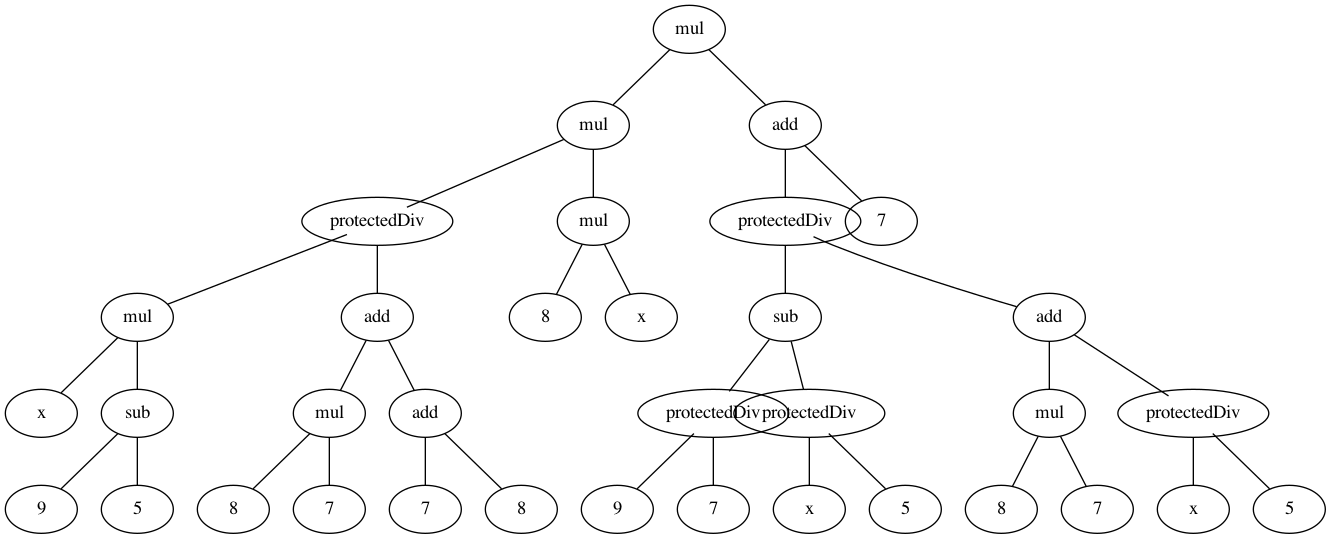

In [14]:
pop = toolbox.population(n=300)
hof = tools.HallOfFame(1)

mstats = stats()

pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.1, ngen=500, stats=mstats, halloffame=hof, verbose=True)


plot(hof)

# Display the tree
from IPython.display import Image
Image(filename="tree0.png")